In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import functools
import pprint

import orbax.checkpoint
import jax
import jax.numpy as jnp
import torch.utils.data.dataloader
import tensorflow as tf
import sqlalchemy as sa
import seaborn as sns
sns.set_style('whitegrid')
import pandas as pd
import matplotlib.pyplot as plt

from userdiffusion import samplers, unet
from userfm import cs, datasets, diffusion, sde_diffusion, utils, main as main_module

In [3]:
engine = cs.get_engine()
cs.create_all(engine)
session = cs.orm.Session(engine)
session.begin()

In [4]:
config_alt_ids = [
    'fyralbgq',
]

In [10]:
cfgs = session.execute(sa.select(cs.Config).where(cs.Config.alt_id.in_(config_alt_ids)))
cfgs = [c for (c,) in cfgs]
reference_cfg = cfgs[0]

In [11]:
key = jax.random.key(reference_cfg.rng_seed)

In [13]:
key, key_dataset = jax.random.split(key)
ds = datasets.get_dataset(reference_cfg.dataset, key=key_dataset)
splits = datasets.split_dataset(reference_cfg.dataset, ds)
dataloaders = {}
for n, s in splits.items():
    dataloaders[n] = torch.utils.data.dataloader.DataLoader(
        list(tf.data.Dataset.from_tensor_slices(s).batch(reference_cfg.dataset.batch_size).as_numpy_iterator()),
        batch_size=1,
        collate_fn=lambda x: x[0],
    )
data_std = splits['train'].std()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:33<00:00, 14.73it/s]


In [19]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
x_sample = next(iter(dataloaders['train']))

cfg_info = {}
for cfg in cfgs:
    assert cfg.rng_seed == reference_cfg.rng_seed
    assert cfg.dataset == reference_cfg.dataset

    cfg_unet = unet.unet_64_config(
        splits['train'].shape[-1],
        base_channels=cfg.model.architecture.base_channel_count,
        attention=cfg.model.architecture.attention,
    )
    model = unet.UNet(cfg_unet)
    # just create params, restore saved weights later
    params = model.init(
        jax.random.key(0),
        x=jnp.ones(x_sample.shape),
        t=jnp.ones(x_sample.shape[0]),
        train=False,
        cond=main_module.condition_on_initial_time_steps(x_sample, cfg.dataset.time_step_count_conditioning),
    )
    ema_params = orbax_checkpointer.restore(cfg.run_dir/'epoch_9999_ema')

    cfg_info[cfg.alt_id] = dict(
        cfg=cfg,
        model=model,
        ema_params=ema_params,
    )

In [20]:
# evaluation_trajectories = ds.Zs[reference_cfg.dataset.batch_size:][:reference_cfg.dataset.batch_size]
evaluation_trajectories = next(iter(dataloaders['val']))

In [22]:
cond = main_module.condition_on_initial_time_steps(evaluation_trajectories, reference_cfg.dataset.time_step_count_conditioning)
trajectory_count = reference_cfg.dataset.batch_size
for config_alt_id, info in cfg_info.items():
    cfg = info['cfg']
    key, key_samples = jax.random.split(key)
    if isinstance(cfg.model, cs.ModelDiffusion):
        @jax.jit
        def score(x, t):
            if not hasattr(t, 'shape') or not t.shape:
                t = jnp.ones(x.shape[0]) * t
            return diffusion.score(info['model'], info['ema_params'], difftype, data_std, x, t, train=False, cond=cond)
            
        difftype = sde_diffusion.get_sde_diffusion(cfg.model.sde_diffusion)
        samples = samplers.sde_sample(difftype, score, key_samples, x_shape=x_sample.shape, nsteps=reference_cfg.model.sde_time_steps)
        info['difftype'] = difftype
        info['samples'] = samples
    elif isinstance(cfg.model, cs.ModelFlowMatching):
        @jax.jit
        def velocity(x, t):
            if not hasattr(t, 'shape') or not t.shape:
                t = jnp.ones(x.shape[0]) * t
            return -info['model'].apply(info['ema_params'], x=x, t=t, train=False, cond=cond)
        
        samples = samplers.ode_sample_taos(velocity, 1., key_samples, x_shape=x_sample.shape, nsteps=1_000)
        info['samples'] = samples
    else:
        raise ValueError(f'Unknown model: {cfg.model}')

In [24]:
for info in cfg_info.values():
    info['relative_error'] = utils.relative_error(evaluation_trajectories, info['samples'])

In [25]:
info['relative_error'].shape

(500, 60)

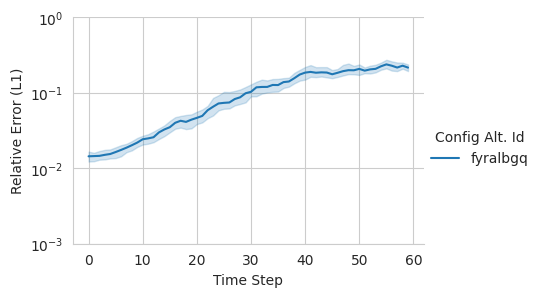

In [32]:
for info in cfg_info.values():
    df = (
        pd.DataFrame(info['relative_error'])
        .melt(var_name='Time Step', value_name='Relative Error (L1)')
    )
    info['relative_error_df'] = df
df = pd.concat([
    info['relative_error_df']
    for info in cfg_info.values()
], keys=cfg_info, names=['Config Alt. Id']).reset_index('Config Alt. Id')
sns.relplot(
    kind='line',
    estimator='median',
    data=df,
    x='Time Step',
    y='Relative Error (L1)',
    hue='Config Alt. Id',
    height=3,
    aspect=1.5,
).set(
    yscale='log',
    ylim=(1e-3, 1),
)

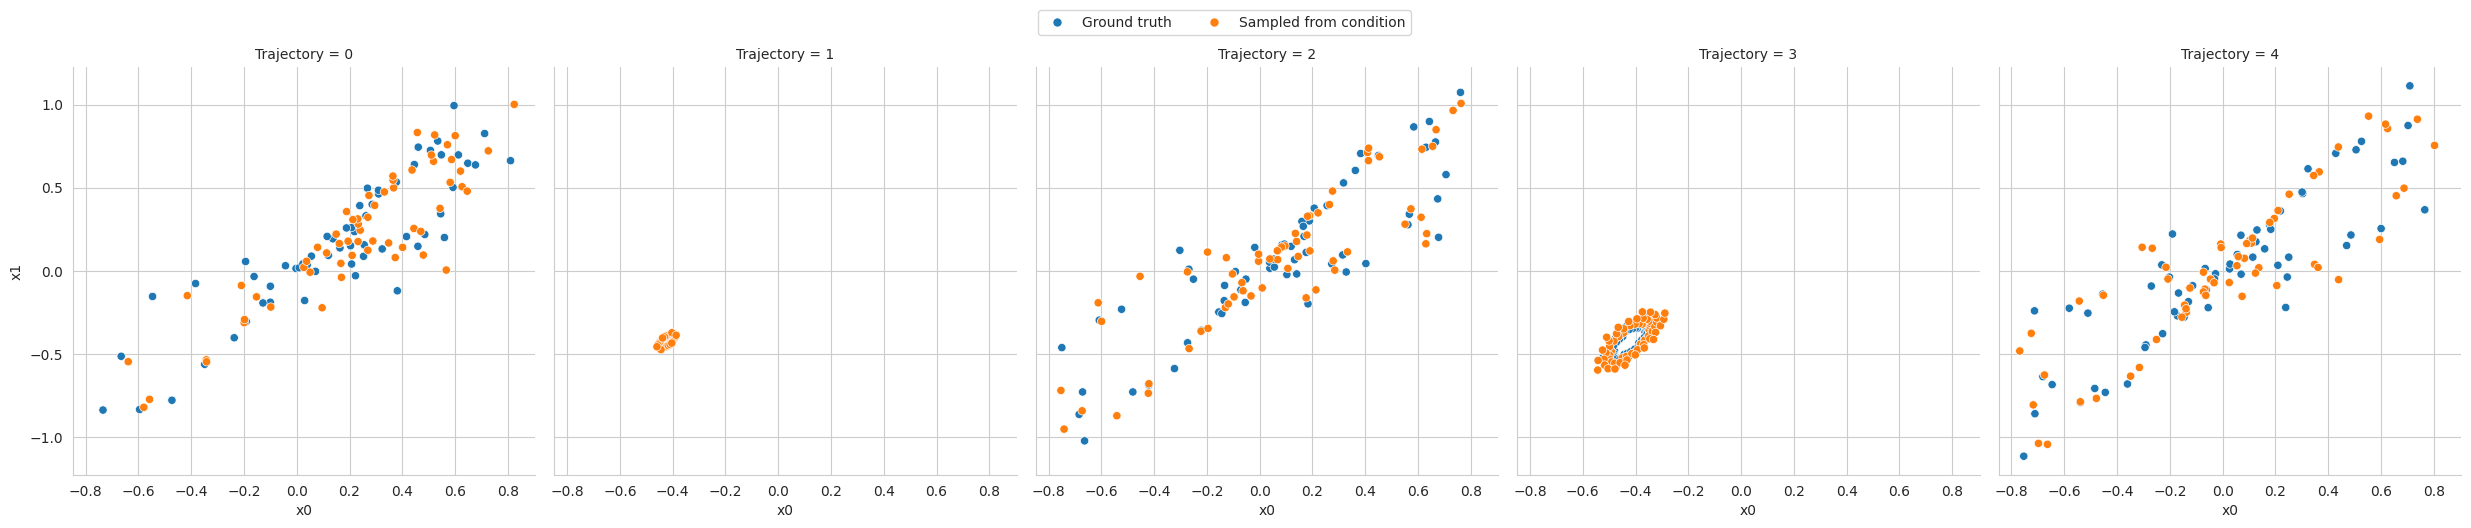

In [53]:
config_alt_id = 'fyralbgq'
trajectory_count = 5
df = pd.concat([
    *[
        pd.DataFrame(dict(
            IsData='Ground truth', Trajectory=str(i), x0=evaluation_trajectories[i, :, 0], x1=evaluation_trajectories[i, :, 1]
        ))
        for i in range(trajectory_count)
    ],
    *[
        pd.DataFrame(dict(
            IsData='Sampled from condition', Trajectory=str(i), x0=cfg_info[config_alt_id]['samples'][i, :, 0], x1=cfg_info[config_alt_id]['samples'][i, :, 1]
        ))
        for i in range(trajectory_count)
    ],
]).reset_index(names=['Time Step'])
share_axes = True
center_axes = False
plot = sns.relplot(
    data=df,
    x='x0', y='x1',
    hue='IsData',
    col='Trajectory',
    facet_kws=dict(
        sharex=share_axes,
        sharey=share_axes,
    )
)
xmax, ymax = df[['x0', 'x1']].max(axis=0) + .4
for (row, col, hue), data in plot.facet_data():
    ax = plot.axes[row][col]
    if not share_axes:
        xmax, ymax = data[['x0', 'x1']].max(axis=0) + .4
    if center_axes:
        ax.set_xlim(xmin=-xmax, xmax=xmax)
        ax.set_ylim(ymin=-ymax, ymax=ymax)
        ax.set_aspect('equal')
        ax.plot([0], [0], 'kx')
sns.move_legend(
    plot,
    loc='upper center',
    ncol=2,
    title='',
    # labels=[],
    bbox_to_anchor=(.455, 1.06),
    frameon=True,
    fancybox=True,
)

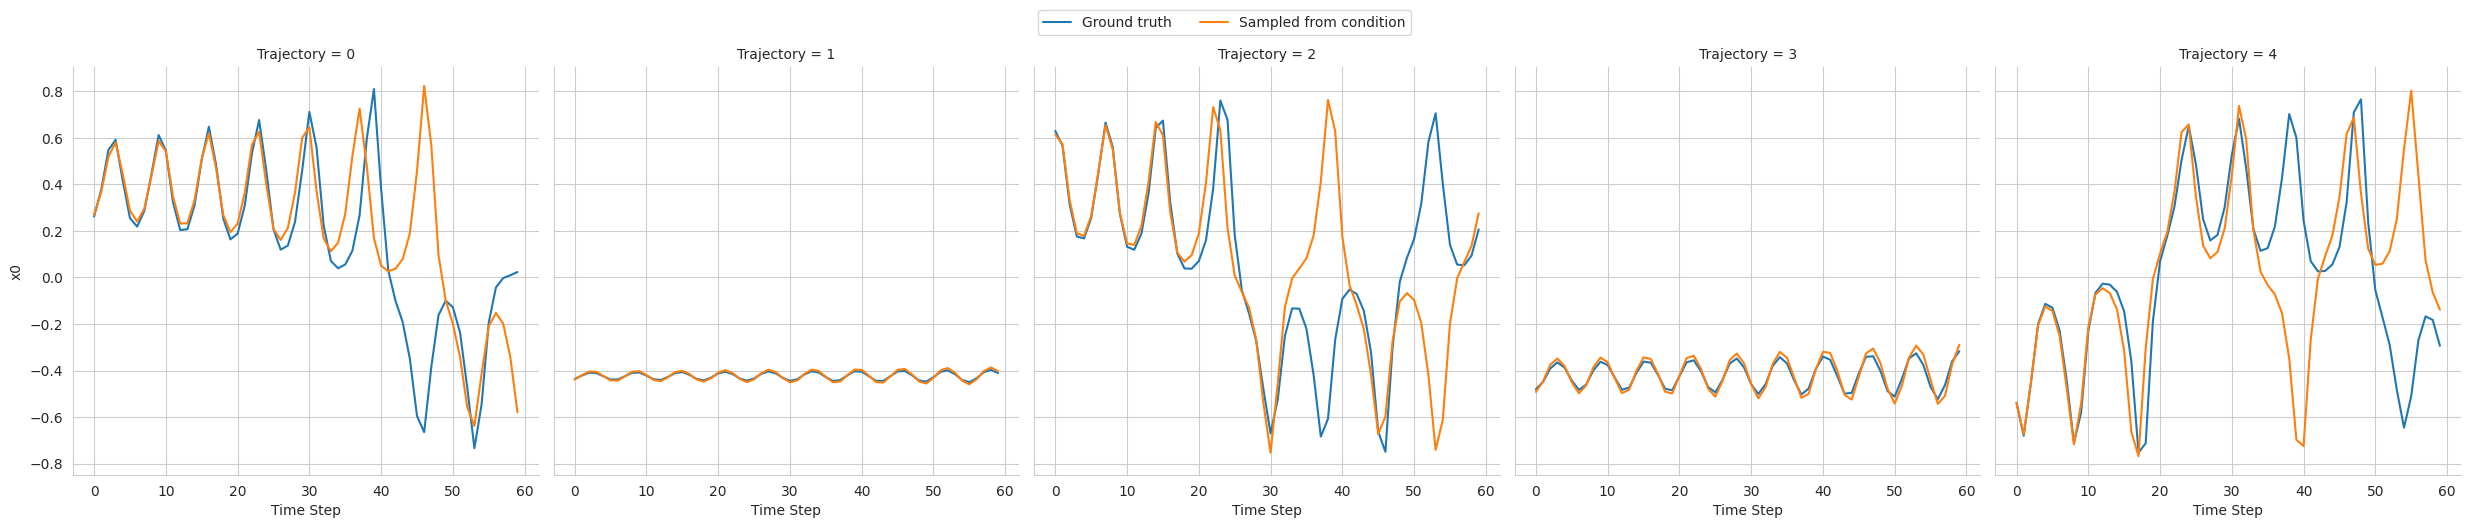

In [48]:
plot = sns.relplot(
    kind='line',
    data=df,
    x='Time Step',
    y='x0',
    hue='IsData',
    col='Trajectory'
)
sns.move_legend(
    plot,
    loc='upper center',
    ncol=2,
    title='',
    # labels=[],
    bbox_to_anchor=(.455, 1.06),
    frameon=True,
    fancybox=True,
)

In [26]:
# session.close()